In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense

In [47]:
def load_coffee_data(seed = 2):
    """Creates a coffee roasting data set.
    roasting duration: 12-15 minutes is best
    temperature range: 175-260C is best
    """
    rng = np.random.default_rng(seed)
    X = rng.random(400).reshape(-1, 2)
    X[:, 1] = X[:, 1] * 4 + 11.5  # 12-15 min is best
    X[:, 0] = X[:, 0] * (285 - 150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))

    i = 0
    for t, d in X:
        y = -3 / (260 - 175) * t + 21
        if t > 175 and t < 260 and d > 12 and d < 15 and d <= y:
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1, 1))


In [ ]:
X, y = load_coffee_data()

df = pd.DataFrame(X, columns=['Temperature (celsius)', 'Time (minutes)'])
df["Good Coffee"] = y

df.head()

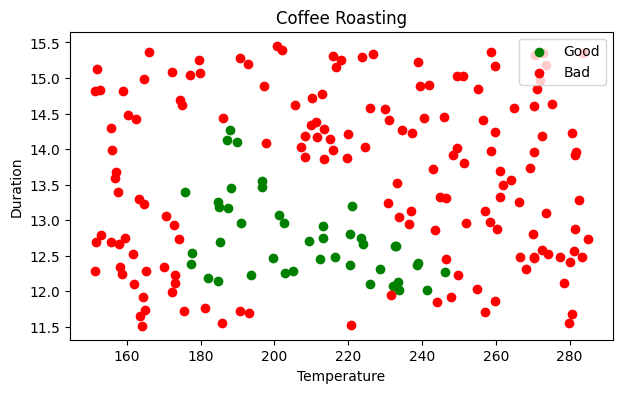

In [5]:
def plot_data(X, y):
  y = y.reshape((-1, ))
  bad = y == 0
  good = y == 1

  plt.figure(figsize=(7, 4))
  plt.scatter(X[good, 0], X[good, 1], c="g", marker='o')
  plt.scatter(X[bad, 0], X[bad, 1], c="r")
  plt.xlabel("Temperature")
  plt.ylabel("Duration")
  plt.title("Coffee Roasting")
  plt.legend(["Good", "Bad"], loc="upper right")

plot_data(X, y)

In [6]:
# Normalization
print(f"Pre-normalization : Temperature min({X[:, 0].min():0.2f}), max({X[:, 0].max():0.2f})")
print(f"Pre-normalization : Duration min({X[:, 1].min():0.2f}, max({X[:, 1].max():0.2f}))")

normal = tf.keras.layers.Normalization(axis = -1)
normal.adapt(X) # Learns mean and variance

Xn = normal(X)
print(f"Post-normalization : Temperature min({np.min(Xn[:, 0]):0.2f}), max({np.max(a=Xn[:, 0]):0.2f})")
print(f"Post-normalization : Duration min({np.min(Xn[:, 1]):0.2f}, max({np.max(Xn[:, 1]):0.2f}))")

Pre-normalization : Temperature min(151.32), max(284.99)
Pre-normalization : Duration min(11.51, max(15.45))
Post-normalization : Temperature min(-1.69), max(1.66)
Post-normalization : Duration min(-1.70, max(1.79))


In [7]:
Xt = np.tile(Xn, (1000, 1)) # Repeating the data to simulate bigger dataset
Yt = np.tile(y, (1000, 1)) # (100, 1) -> 100 times in col rep, and 1 time in row rep

print(Xt.shape, Yt.shape)

(200000, 2) (200000, 1)


## Building Model

In [8]:
tf.random.set_seed(1234)
model = Sequential(
  [
    Input(shape=(2,)),
    Dense(3, activation="sigmoid", name="Layer1"),
    Dense(1, activation="sigmoid", name="Layer2"),
  ]
)

In [9]:
model.summary()

# params -> 3 neurons in l1 -> (3 neurons * 2 weights) + (3 bias for 3 neurons)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
W1, b1 = model.get_layer("Layer1").get_weights()
W2, b2 = model.get_layer("Layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print()
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.07879031  0.02676618  1.0933225 ]
 [ 0.22571456  1.010715   -0.81528825]] 
b1(3,): [0. 0. 0.]

W2(3, 1):
 [[0.8675276]
 [0.5749022]
 [0.9229766]] 
b2(1,): [0.]


In [62]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=30,
)

Epoch 1/30


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 786us/step - loss: 2.3305e-05
Epoch 2/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 757us/step - loss: 2.6073e-05
Epoch 3/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 867us/step - loss: 1.4299e-05
Epoch 4/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 2.0151e-05
Epoch 5/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.2062e-05
Epoch 6/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.7414e-05
Epoch 7/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 2.1240e-04
Epoch 8/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 1.5077e-05
Epoch 9/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 8.6500e-06
Epoch 10/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 1.9643e-04
Epoch 11/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 1.2713e-05
Epoch 12/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 6.4836e-06
Epoch 13/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 8.4762e-06
Epoch 14/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/st

In [40]:
## Updated Weights and Bias -

W1, b1 = model.get_layer("Layer1").get_weights()
W2, b2 = model.get_layer("Layer2").get_weights()

print("W1:\n", W1, "\nb1:", b1)
print()
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-11.8667965   -0.17809293  15.611802  ]
 [ -0.2543187   -9.472628    13.020799  ]] 
b1: [-12.846691 -11.724071   2.214935]

W2:
 [[-68.53825 ]
 [-64.34931 ]
 [-55.976044]] 
b2: [37.980904]


In [42]:
# Setting weights
# ! These weights are better than the one generated by model

W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )

b1 = np.array([-9.87, -9.28,  1.01])

W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])

model.get_layer("Layer1").set_weights([W1,b1])
model.get_layer("Layer2").set_weights([W2,b2])

In [75]:
X_test, y_test = load_coffee_data(6)

X_test_normalized = normal(X_test)
predictions = model.predict(X_test_normalized)

res = (predictions >= 0.5).astype(int)

print("Wrong predictions = \n", np.count_nonzero(res != y_test)) # Gives number of wrong predictions

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Wrong predictions = 
 5
